# CMPT 898: Assigment 2 Solutions
## By Samuel Horovatin, sch923, 11185403

### Question 1: *Re-implement the Keras tutorial for image classification in TensorFlow without using tf.keras objects.*

In [135]:
import tensorflow as tf
import numpy as np
import os, datetime
import math

epochs = 5
hidden_layer_size = 512
output_layer_size = 10
alpha = 0.01

(x_train, y_train),(x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalization of x_train and x_test
x_train, x_test = x_train / 255.0, x_test / 255.0

In [168]:
# Takes a tensor and by default flattens it to 1 by size of the input tensor
def flatten(tensor):
  return tf.Variable(tf.reshape(tensor, [tf.size(tensor),1]))

# A relu density function. Takes a tensor x, scalar wieght W, and tensor bias b.
def dense_relu(x, W, b):
  return tf.nn.relu(tf.matmul(W,x) + b)

# A dropout function that by default converts 20% of the input tensor x to 0.
def dropout(tensor,rate=0.2):
  return tf.nn.dropout(tensor, rate)

# A softmax density function. Takes a tensor x, scalar wieght W, and a tensor b.
def dense_softmax(x, W, b):
  return tf.nn.softmax(tf.matmul(W,x) + b, axis=0)

# A cross entropy loss function that takes in a vector of actual probabilities and a vector of predicted probabilities
def cross_entropy(actual_p, predicted_p):
  pre_sum_matrix = tf.multiply(actual_p, tf.math.log(predicted_p))
  return (-tf.math.reduce_sum(pre_sum_matrix))

# Generates random weights using the Xavier uniform initializer, similar to the GlorotUniform in keras
def gen_xavier_weights(m, n, name):
  limit = math.sqrt(6./ (m + n))
  return tf.Variable(
      tf.random_uniform_initializer(minval=-limit, maxval=limit)(shape=[m, n],
      dtype=tf.float64), trainable=True, name=name)

# Generates zeros tensor of size m by 1 for use as bias
def gen_zero_bias(m, name):
  return tf.Variable(tf.zeros(shape=[m,1],dtype=tf.float64), trainable=True, name=name)

'''
def gradiant_step_optimizer(weights, actual_p, predicted_p, alpha=0.1):
  with tf.GradientTape() as tape:
    tape.watch(actual_p)
    tape.watch(predicted_p)
    y = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=actual_p, labels=predicted_p)
  grad = tape.gradient(y, [actual_p, predicted_p])[0]
  print(f"grad shape {grad.shape}")  
  return weights - alpha*grad.numpy()
'''

def train_model(epochs, x_train, y_train):
  # initialize weights and biases to random values
  weight_1 = gen_xavier_weights(hidden_layer_size, x_train[0].size, 'weight_1')
  weight_2 = gen_xavier_weights(output_layer_size, hidden_layer_size, 'weight_2')
  bias_1 = gen_zero_bias(hidden_layer_size, 'bias_1')
  bias_2 = gen_zero_bias(output_layer_size, 'bias_2')
  
  for i in range(epochs):
    for x_tens, y_tens in zip(x_train, y_train):  
      
      y_tens = tf.transpose(
          tf.Variable(
            tf.one_hot(
                [y_tens],
                10, 
                dtype=tf.float64)
          )
      )
      x_estimate = flatten(x_tens)

      with tf.GradientTape() as tape:
        x_estimate = flatten(x_tens)
        x_estimate = dense_relu(x_estimate, weight_1, bias_1)
        x_estimate = dropout(x_estimate)
        x_estimate = dense_softmax(x_estimate, weight_2, bias_2)
        y = cross_entropy(y_tens, x_estimate)


      #update weights and bias
      grad = tape.gradient(y, {'weight_1': weight_1, 'weight_2': weight_2, 'bias_1': bias_1, 'bias_2': bias_2})
      weight_2 = tf.Variable(tf.subtract(weight_2, (alpha*grad['weight_2'].numpy())))
      bias_2 = tf.Variable(tf.subtract(bias_2, (alpha*grad['bias_2'].numpy())))
      weight_1 = tf.Variable(tf.subtract(weight_1, (alpha*grad['weight_1'].numpy())))
      bias_1 = tf.Variable(tf.subtract(bias_1, (alpha*grad['bias_1'].numpy())))
      

    print(f"Epoch {i} complete")
    # print(f"weight_1 after epoch {weight_1[0:10]}")
    # print(f"weight_2 after epoch {weight_2[0:10]}")
    # print(f"bias_1 after epoch {bias_1[0:10]}")
    # print(f"bias_2 after epoch {bias_2}")
  
  return weight_1, weight_2, bias_1, bias_2

def evaluate_model(x_test, y_test, weight_1, weight_2, bias_1, bias_2):
  # Define our metrics
  test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
  test_accuracy = tf.keras.metrics.CategoricalAccuracy('test_accuracy')

  for x_tens, y_tens in zip(x_test, y_test):
    x_estimate = network_step(x_tens, weight_1, weight_2, bias_1, bias_2)

    loss = cross_entropy(y_test, x_estimate)
    test_loss(loss)
    test_accuracy(y_test, x_estimate)

    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    test_log_dir = 'logs/gradient_tape/' + current_time + '/test'
    test_summary_writer = tf.summary.create_file_writer(test_log_dir)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

weight_1, weight_2, bias_1, bias_2 = train_model(epochs, x_train[0:50], y_train[0:50])

Epoch 0 complete
weight_2 after epoch [[-9.11546744e-02  4.07590922e-03  8.10278637e-02 ...  7.53809755e-04
  -6.49539052e-02  1.04542121e-02]
 [-4.60157495e-02 -3.12089411e-02  4.77865282e-02 ...  5.72677629e-02
  -1.17409611e-02  2.79232242e-02]
 [-9.28548538e-02  9.41714930e-03 -1.00122101e-01 ... -1.03755569e-02
   6.70599441e-05  8.27835888e-02]
 ...
 [-2.17713083e-02  2.40103655e-02 -1.54927146e-02 ... -5.46039025e-02
  -8.09768851e-02  7.04057418e-02]
 [-1.00024659e-01  4.79576662e-02 -6.79184441e-02 ... -5.72597370e-03
  -2.85505877e-02  5.65616599e-02]
 [-9.69859501e-02  6.88042699e-02  1.05665622e-01 ...  3.45058449e-02
  -6.62617965e-02  1.13405979e-01]]
Epoch 1 complete
weight_2 after epoch [[-0.09243577  0.00195872  0.08068496 ...  0.0015537  -0.06470604
   0.00492315]
 [-0.0444642  -0.03051698  0.04757734 ...  0.06209051 -0.01059231
   0.01985016]
 [-0.09305443  0.00712219 -0.10021383 ... -0.01318815 -0.00350891
   0.08530968]
 ...
 [-0.02196273  0.02245659 -0.01554227 ..

### Question 2: Create two random square matrix and preform matrix multiplication. Create a table to report the compute time for CPU vs GPU for matrix size 500, 1000, 5000, 10000.

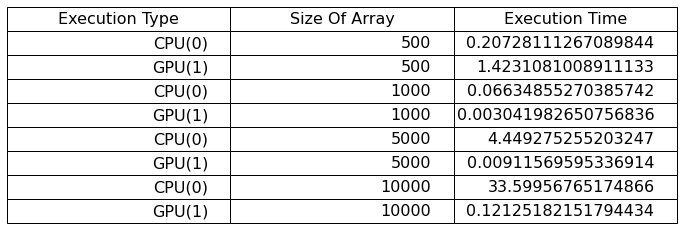

In [1]:
import tensorflow as tf
import time
import pandas as pd
import matplotlib.pyplot as plt

# Generates a random square matrix of size x 
def gen_square_matrix(x):
  return tf.Variable( tf.random.normal(shape=[x,x],seed=43) )

# Generates two random square matrix of size x 
# and reports the time in seconds it takes to matrix multiply them.
def time_matrix_multiplication(x):
    start_time = time.time()
    tf.matmul(gen_square_matrix(x), gen_square_matrix(x))
    elapse_time = time.time()-start_time
    return elapse_time

# Preform CPU Multiplication
with tf.device('/cpu:0'):
  CPU_time_500 = time_matrix_multiplication(500)
  CPU_time_1000 = time_matrix_multiplication(1000)
  CPU_time_5000 = time_matrix_multiplication(5000)
  CPU_time_10000 = time_matrix_multiplication(10000)

# Preform GPU Multiplication
with tf.device('/device:GPU:0'):
  GPU_time_500 = time_matrix_multiplication(500)
  GPU_time_1000 = time_matrix_multiplication(1000)
  GPU_time_5000 = time_matrix_multiplication(5000)
  GPU_time_10000 = time_matrix_multiplication(10000)

# Create table
fig, axes = plt.subplots()

# Hides unneeded axes
fig.patch.set_visible(False)
axes.axis('off')
axes.axis('tight')

# Data assembly
tablelabel = ("Execution Type", "Size Of Array", "Execution Time")
tabledata = ([("CPU(0)", 500, CPU_time_500),
              ("GPU(1)", 500, GPU_time_500),
              ("CPU(0)", 1000, CPU_time_1000), 
              ("GPU(1)", 1000, GPU_time_1000),
              ("CPU(0)", 5000, CPU_time_5000), 
              ("GPU(1)", 5000, GPU_time_5000),
              ("CPU(0)", 10000, CPU_time_10000),
              ("GPU(1)", 10000, GPU_time_10000)])
table_df = pd.DataFrame(tabledata, columns=tablelabel)
 
# Plot table with some formatting
table = axes.table(cellText=table_df.values, colLabels=table_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(16)
table.scale(2,2)
plt.show()

### Question 3: Given the polynomial $y = x^2 + 2x +3$, implement the expression in tensor flow, and print out the result of performing differentiation of the expression. Compare this to the result of evaluating a manually derived expression by hand. Use the test case $x = \begin{pmatrix} 2\\ 4\end{pmatrix}$.

In [ ]:
import tensorflow as tf

#A function that takes a vector x and returns the result of gradiant of x^2 + 2x +3 with the inputted x
def poly_derivative(x):
    if not isinstance(x, tf.Variable):
        x = tf.Variable(x)
    with tf.GradientTape() as tape:
        y = tf.math.multiply(x, x) + 2*x + 3
    return tape.gradient(y, [x])

#First test using the example vector x_1 = (2, 4)^T
for element in poly_derivative([2.,4.]):
    print(element)

#Second test using a larger vector x_2 = (0.5, 10, 4, 8)^T
for element in poly_derivative([0.5, 10., 4., 8.]):
    print(element)

tf.Tensor([ 6. 10.], shape=(2,), dtype=float32)
tf.Tensor([ 3. 22. 10. 18.], shape=(4,), dtype=float32)
